# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

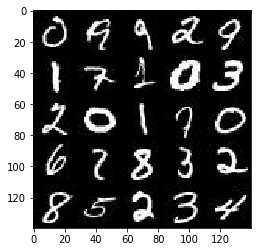

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

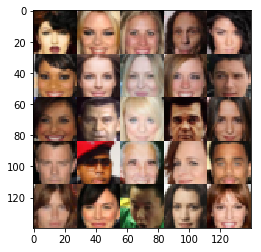

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_images")
    z_data = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
# a function for the leaky relu

def leaky_relu(x, alpha=0.2):
    """
    Takes in a tensor x and optionaly a alpha value and returns the tensor back with leaky relu applied
    """ 
    return tf.maximum(x, x * alpha)

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # layer 1 in 28*28*(1 or 3)
        conv_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                 kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu_1 = leaky_relu(conv_1)
        # 14x14x32
        
        # layer 2
        conv_2 = tf.layers.conv2d(relu_1, 128, 5, strides=2, padding='same', 
                                 kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        conv_2 = tf.layers.batch_normalization(conv_2, training=True)
        relu_2 = leaky_relu(conv_2)
        # 7x7x64
        
        # layer 3
        conv_3 = tf.layers.conv2d(relu_2, 256, 5, strides=2, padding='same', 
                                 kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        conv_3 = tf.layers.batch_normalization(conv_3, training=True)
        relu_3 = leaky_relu(conv_3)
        # 4x4x128 - double check

        # layer 4
        conv_4 = tf.layers.conv2d(relu_3, 512, 5, strides=2, padding='same', 
                                 kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        conv_4 = tf.layers.batch_normalization(conv_4, training=True)
        relu_4 = leaky_relu(conv_4)
        # 4x4x128 - double check
        
        # output layer
        flat = tf.contrib.layers.flatten(relu_4)
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # layer 1 input is z, a flat vector
        layer_1 = tf.layers.dense(z, 4*4*512)
        
        layer_1 = tf.reshape(layer_1,(-1,4,4,512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = leaky_relu(layer_1)
        # 4x4x512
        
        # layer 2
        conv_1 = tf.layers.conv2d_transpose(layer_1, 256, 4, strides=1, padding='valid', 
                                           kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        conv_1 = tf.layers.batch_normalization(conv_1, training=is_train)
        conv_1 = leaky_relu(conv_1)
        # 7x7x256
        
        # layer 3
        conv_2 = tf.layers.conv2d_transpose(conv_1, 128, 5, strides=2, padding='same')
        conv_2 = tf.layers.batch_normalization(conv_2, training=is_train)
        conv_2 = leaky_relu(conv_2)
        # 14x14x128
        
        # layer 4
        conv_3 = tf.layers.conv2d_transpose(conv_2, 64, 5, strides=2, padding='same')
        conv_3 = tf.layers.batch_normalization(conv_3, training=is_train)
        conv_3 = leaky_relu(conv_3)
        # 28x28x64
        
        # output - shape stays the same, but channels are reduced to final shape
        logits = tf.layers.conv2d_transpose(conv_3, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_output_real, d_logits_real = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_output_real) * smooth))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate=0.01, beta1=0.5):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    
    # need this to make batch normalization work properly during inference
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates  = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # input shape
    _, image_width, image_height, image_channels = data_shape
    
    # model inputs
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # model losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # optimization
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    samples = []
    losses = []
    steps = 0
    print_loss_every = 40
    show_images_every = 80
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Get images, reshape and rescale to pass to D
                # images are b/w -0.5 to 0.5, so rescaling to -1 to 1
                batch_images = batch_images * 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})
                
                steps += 1
                
                # get the losses and print them out every so often
                if steps % print_loss_every == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), 
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # show generated images every so often
                if steps % show_images_every == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4090... Generator Loss: 2.9103
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 2.0094


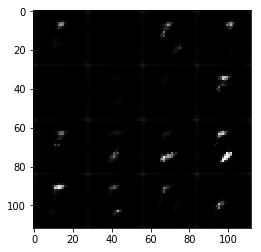

Epoch 1/2... Discriminator Loss: 0.7271... Generator Loss: 1.6697
Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 0.7704


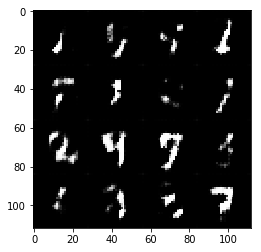

Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 2.6230
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 1.2048


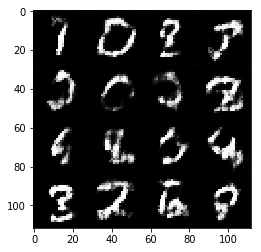

Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 1.0086
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.9352


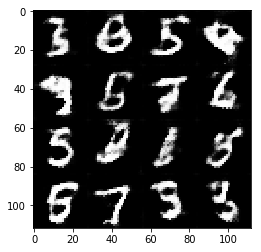

Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 1.1439
Epoch 1/2... Discriminator Loss: 1.1393... Generator Loss: 0.8828


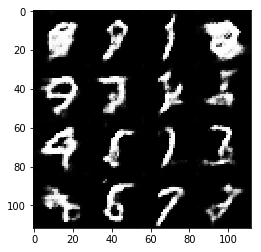

Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 1.3973
Epoch 1/2... Discriminator Loss: 1.6019... Generator Loss: 1.4282


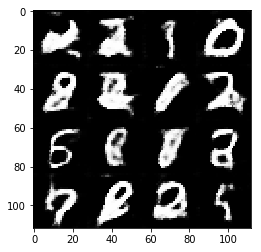

Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 1.1403
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.5444


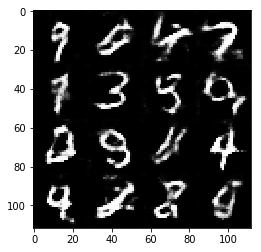

Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 1.4505... Generator Loss: 1.9792


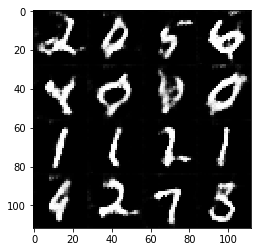

Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 1.4168
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 0.8722


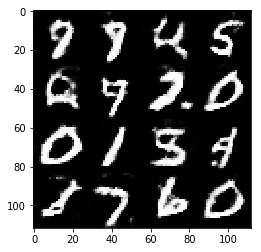

Epoch 1/2... Discriminator Loss: 1.3463... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 0.8535


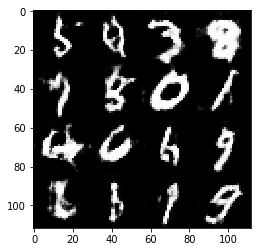

Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 1.0935
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.7641


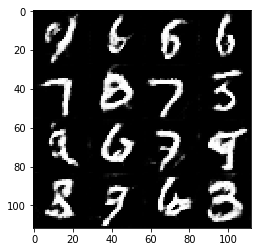

Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 1.4179
Epoch 2/2... Discriminator Loss: 1.8066... Generator Loss: 0.3781


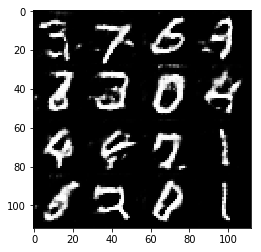

Epoch 2/2... Discriminator Loss: 1.7583... Generator Loss: 1.6516
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 1.2746


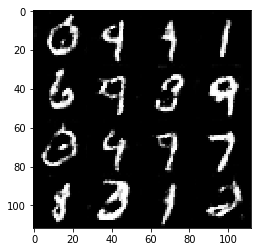

Epoch 2/2... Discriminator Loss: 1.5699... Generator Loss: 0.4001
Epoch 2/2... Discriminator Loss: 0.8194... Generator Loss: 1.9369


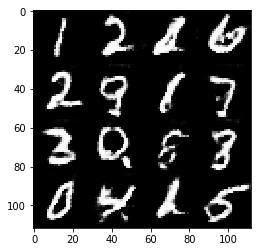

Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.5914


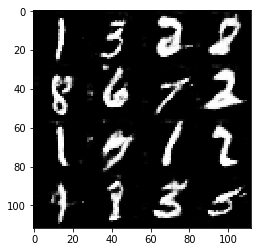

Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 0.8426


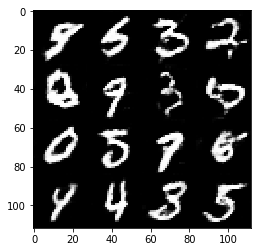

Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 2.3145


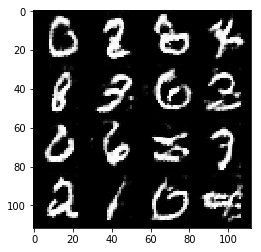

Epoch 2/2... Discriminator Loss: 0.9265... Generator Loss: 1.7622
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.0511


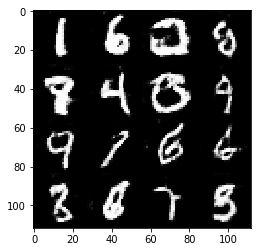

Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 1.1994
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 1.0654


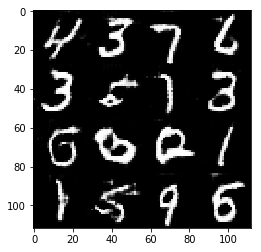

Epoch 2/2... Discriminator Loss: 0.7220... Generator Loss: 1.7514
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 1.2004


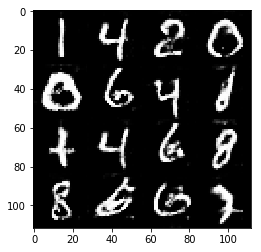

Epoch 2/2... Discriminator Loss: 2.3136... Generator Loss: 0.2325
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.1573


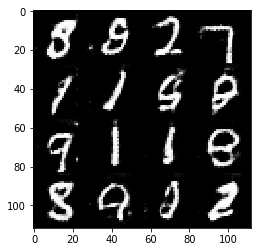

Epoch 2/2... Discriminator Loss: 0.7673... Generator Loss: 1.1967
Epoch 2/2... Discriminator Loss: 0.9430... Generator Loss: 0.9212


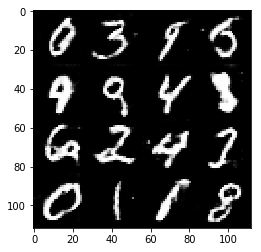

Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 1.6587


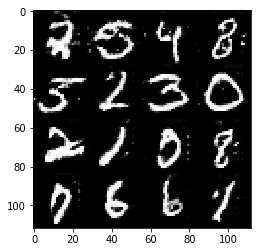

In [23]:
tf.reset_default_graph()

batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6758... Generator Loss: 0.2816
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.7291


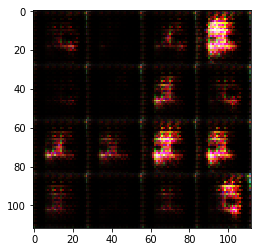

Epoch 1/1... Discriminator Loss: 2.5778... Generator Loss: 0.3832
Epoch 1/1... Discriminator Loss: 2.1436... Generator Loss: 0.2918


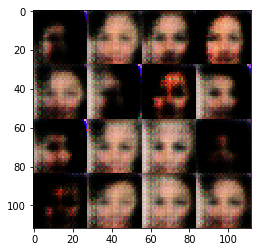

Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 1.5906
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.5052


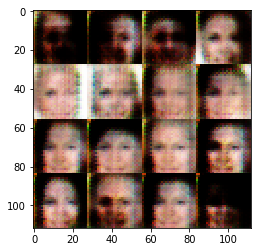

Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 1.7119
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 2.6307


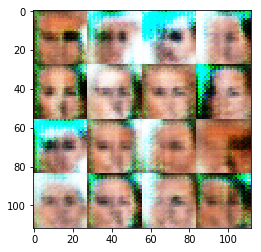

Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.4750


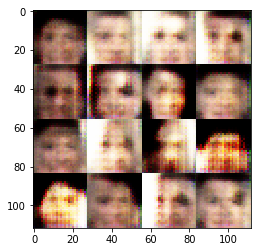

Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.6214


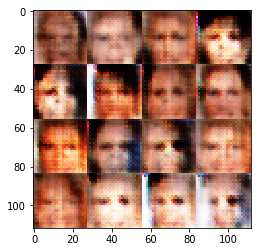

Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 1.9619
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.4391


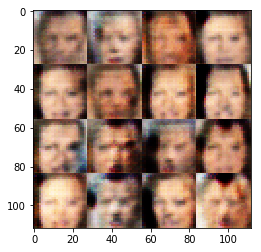

Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.1194


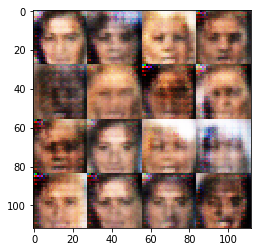

Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.7982


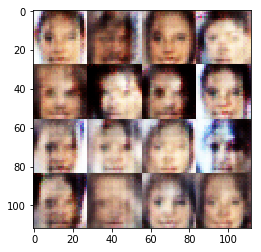

Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.5302


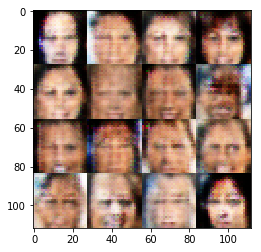

Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.7661


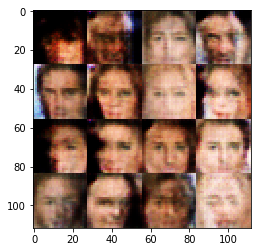

Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.3444
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.7668


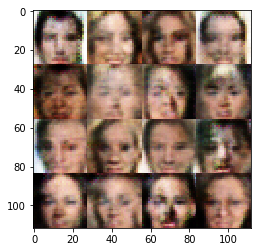

Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.6493


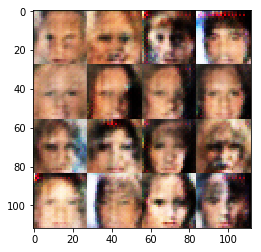

Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6532


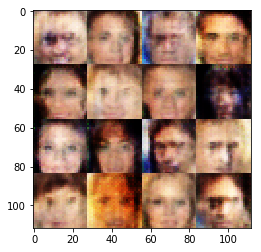

Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.6840


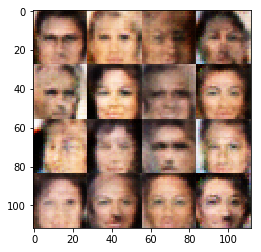

Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.8577... Generator Loss: 0.2733


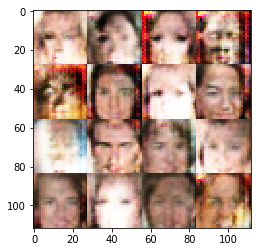

Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.9178


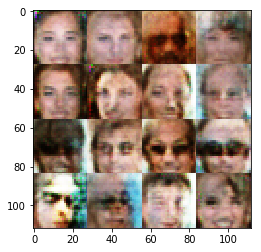

Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.5962


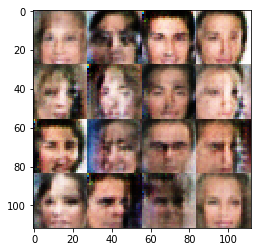

Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.8334


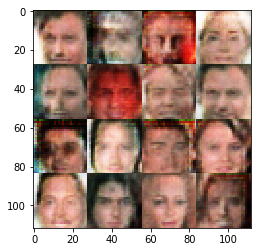

Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.9668


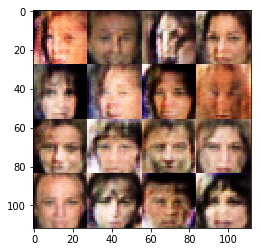

Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.9716


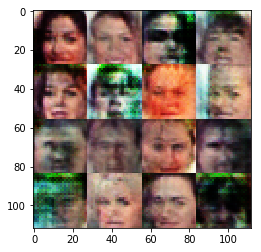

Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.5695... Generator Loss: 0.5657


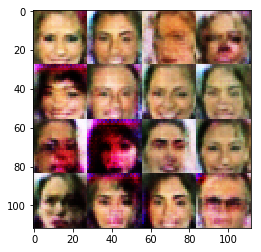

Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.8327


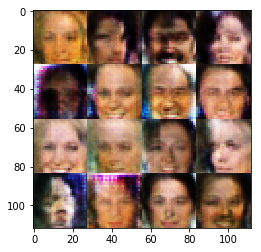

Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 1.6522
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.8833


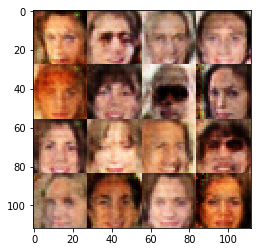

Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8198


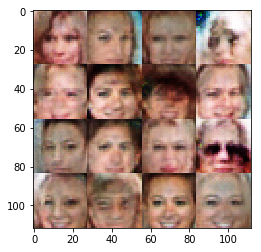

Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.0530


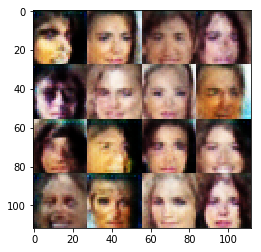

Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7998


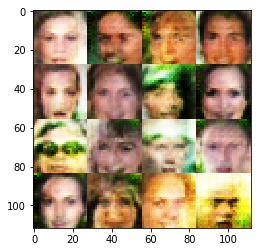

Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.6982... Generator Loss: 1.6575


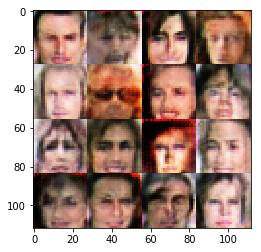

Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 1.1648


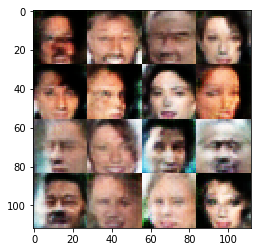

Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.0211


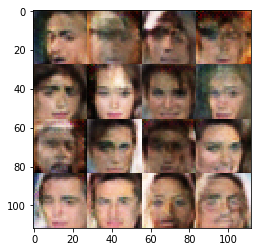

Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8482


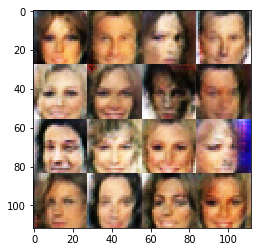

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.9379


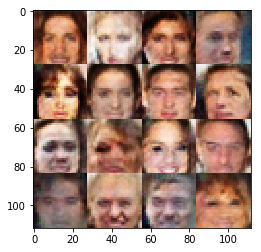

Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.7974


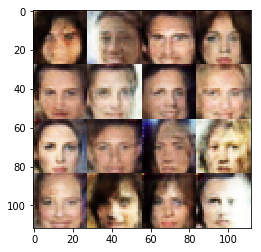

Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.9889


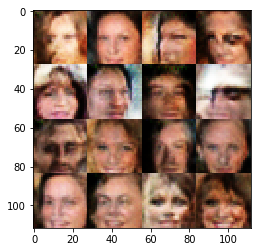

Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.5113


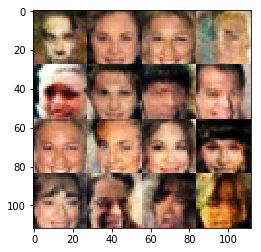

Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.6572


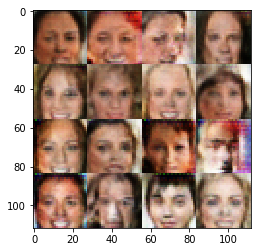

Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.8190


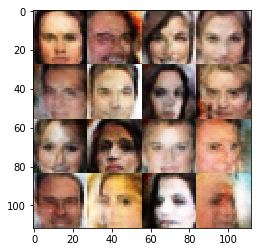

Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.9933


KeyboardInterrupt: 

In [24]:
tf.reset_default_graph()

batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.